In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import seaborn as sns
import prophet as pt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr

sns.set_style('whitegrid')
plt.style.use("default")
yf.pdr_override()
%matplotlib inline


d:\Time-series-forecasting\tsf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


df = pd.DataFrame(listing_companies())\
search_word = 'mobile'\
result = df[df['organName'].str.contains(search_word)]\
print(result)

Vin = VIC\
Viettel = VGI\
FPT = FPT\
thế giới di động = MWG\
Petrolimex = PLC

In [ ]:
df = pd.DataFrame(listing_companies())\
search_word = 'mobile'\
result = df[df['organName'].str.contains(search_word)]\
print(result)


In [3]:
start_date = dt.datetime(2013, 1, 1)
end_date = dt.datetime(2023, 6, 30)
df = pdr.get_data_yahoo('AAPL', start_date, end_date)
display(df.head())


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791182,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579243,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117435,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022631,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065746,458707200


# TURTLE AGENT

In [4]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals


,signal,trend,RollingMax,RollingMin
Date,,,,
2013-01-02,0.0,19.608213,NaN,NaN
2013-01-03,0.0,19.360714,NaN,NaN
2013-01-04,0.0,18.821428,NaN,NaN
2013-01-07,0.0,18.710714,NaN,NaN
2013-01-08,0.0,18.761070,NaN,NaN
...,...,...,...,...
2023-06-23,0.0,186.679993,187.000000,125.019997
2023-06-26,0.0,185.270004,187.000000,125.019997
2023-06-27,-1.0,188.059998,187.000000,125.019997


In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)

    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest


In [6]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])


day 330: cannot sell anything, inventory 0
day 331: cannot sell anything, inventory 0
day 336: cannot sell anything, inventory 0
day 346: cannot sell anything, inventory 0
day 347: cannot sell anything, inventory 0
day 348: cannot sell anything, inventory 0
day 349: cannot sell anything, inventory 0
day 350: cannot sell anything, inventory 0
day 351: cannot sell anything, inventory 0
day 353: cannot sell anything, inventory 0
day 356: cannot sell anything, inventory 0
day 357: cannot sell anything, inventory 0
day 358: cannot sell anything, inventory 0
day 360: cannot sell anything, inventory 0
day 361: cannot sell anything, inventory 0
day 379: cannot sell anything, inventory 0
day 384: cannot sell anything, inventory 0
day 391: cannot sell anything, inventory 0
day 393: cannot sell anything, inventory 0
day 394: cannot sell anything, inventory 0
day 409: cannot sell anything, inventory 0
day 410: cannot sell anything, inventory 0
day 411: cannot sell anything, inventory 0
day 412: ca

C:\Users\lehun\AppData\Local\Temp\ipykernel_16464\2749411745.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = signal[i]
C:\Users\lehun\AppData\Local\Temp\ipykernel_16464\2749411745.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares = initial_money // real_movement[i]
C:\Users\lehun\AppData\Local\Temp\ipykernel_16464\2749411745.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_money -= buy_units * real

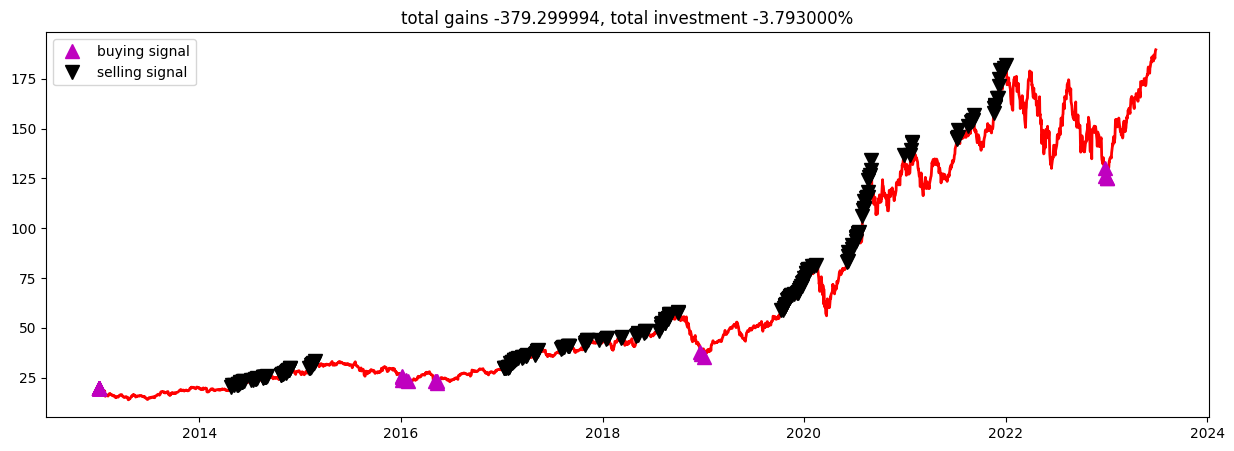

In [7]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()


# LSTM MODEL

In [8]:
def load_data(company, start, end):
    ticker = yf.Ticker(company)
    df = ticker.history(start=start, end=end)
    df.rename(columns={'Close': 'Close'}, inplace=True)
    return df


In [9]:
COMPANY = 'AAPL'
START_DATE_TEST = end_date


In [10]:
data = load_data(company = COMPANY,
                 start = start_date,
                 end = end_date)


In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))


In [12]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [13]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model


In [14]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [23]:
# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5',
    verbose = 2,
    save_best_only = True
)

model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
    callbacks = [checkpointer]
)


Epoch 1/25
81/81 [==============================] - 7s 88ms/step - loss: 0.0010
Epoch 2/25
81/81 [==============================] - 7s 91ms/step - loss: 0.0012
Epoch 3/25
81/81 [==============================] - 7s 92ms/step - loss: 0.0012
Epoch 4/25
81/81 [==============================] - 7s 88ms/step - loss: 0.0011
Epoch 5/25
81/81 [==============================] - 7s 86ms/step - loss: 0.0011
Epoch 6/25
81/81 [==============================] - 7s 85ms/step - loss: 0.0012
Epoch 7/25
81/81 [==============================] - 7s 88ms/step - loss: 0.0012
Epoch 8/25
81/81 [==============================] - 7s 90ms/step - loss: 0.0012
Epoch 9/25
81/81 [==============================] - 8s 95ms/step - loss: 0.0011
Epoch 10/25
81/81 [==============================] - 9s 106ms/step - loss: 0.0011
Epoch 11/25
81/81 [==============================] - 8s 101ms/step - loss: 0.0012
Epoch 12/25
81/81 [==============================] - 8s 95ms/step - loss: 0.0010
Epoch 13/25
81/81 [================

In [16]:
# model.save('model\lstm_model.h5')


In [17]:
# model = load_model('model\lstm_model.h5')


In [28]:
test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)


In [29]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)


3/3 [==============================] - 0s 24ms/step


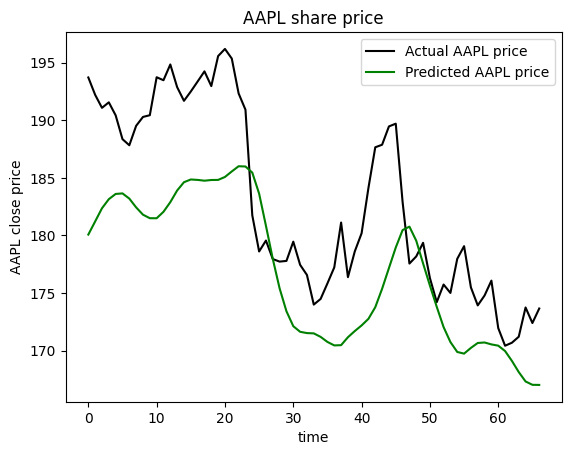

In [30]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} close price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()


In [31]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")


1/1 [==============================] - 0s 38ms/step
Prediction: 167.30239868164062


In [32]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 6.465381223763993
Root Mean Squared Error (RMSE): 7.399034596787271
